# Atmospheric Rivers: Filtering by Criteria

This notebook will import functions from the `ar_detection.py` module to expose the processing flow and to show a few examples.
Production runs could also be orchestrated from this notebook to leverage the use of an interactive Dask client if/when needed. Before executing this notebook be sure you've set your `AR_DATA_DIR` environment variable, and have executed both the `download.py` and `compute_ivt.py` scripts.

In [1]:
import xarray as xr
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import ar_params, ard_fp

# functions to create the binary "blobs" of IVT exceedance
from ar_detection import compute_intensity_mask, label_contiguous_mask_regions
# functions to measure the requisite blob properties
from ar_detection import generate_region_properties, get_data_for_ar_criteria, get_azimuth_of_furthest_points, get_directional_coherence, get_length_width_ratio, get_major_axis_haversine_distance, get_poleward_strength
# functions test whether or not criteria are met
from ar_detection import apply_criteria, filter_ars
# functions to generate vectorized output
from ar_detection import create_geodataframe_with_all_ars, create_shapefile

In [2]:
# inspect the criteria, note that `window` and `ivt_percentile` are used in the IVT computation, not in the AR filtering done here
ar_params

{'window': 75,
 'ivt_percentile': 85,
 'ivt_floor': 100,
 'direction_deviation_threshold': 45,
 'mean_meridional': 50,
 'orientation_deviation_threshold': 45,
 'min_axis_length': 2000}

In [3]:
ivt_ds = xr.open_dataset(ard_fp)
ivt_ds.rio.write_crs("epsg:4326", inplace=True)
ivt_ds
# CP note: retaining in chunk option in case of future memory allocation errors
# ivt_ds = ivt_ds.chunk({"time": "auto"})

<xarray.Dataset>
Dimensions:       (time: 4384, latitude: 141, longitude: 141)
Coordinates:
  * time          (time) datetime64[ns] 2019-01-01 ... 2021-12-31T18:00:00
  * longitude     (longitude) float32 -170.0 -169.8 -169.5 ... -135.2 -135.0
  * latitude      (latitude) float32 65.0 64.75 64.5 64.25 ... 30.5 30.25 30.0
    spatial_ref   int64 0
Data variables:
    p72.162       (time, latitude, longitude) float32 ...
    ivt_mag       (time, latitude, longitude) float32 ...
    ivt_dir       (time, latitude, longitude) float32 ...
    ivt_quantile  (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-28 22:05:12 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
%%time
ivt_ds["thresholded"] = compute_intensity_mask(ivt_ds["ivt_mag"], ivt_ds["ivt_quantile"], ar_params["ivt_floor"])

CPU times: user 838 ms, sys: 674 ms, total: 1.51 s
Wall time: 1.51 s


In [5]:
%%time
labeled_regions = label_contiguous_mask_regions(ivt_ds["thresholded"])

CPU times: user 5.76 s, sys: 133 ms, total: 5.89 s
Wall time: 5.88 s


In [6]:
%%time
ar_di = generate_region_properties(labeled_regions, ivt_ds)

CPU times: user 25.1 s, sys: 1.63 s, total: 26.7 s
Wall time: 26.7 s


In [7]:
%%time
ar_di = get_data_for_ar_criteria(ar_di, ivt_ds)

Getting length/width ratio for each AR candidate for each timeslice...: 100%|████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:09<00:00, 483.62it/s]
Getting axis length (km) for each AR candidate for each timeslice...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:18<00:00, 232.66it/s]
Getting overall orientation (azimuth) for each AR candidate for each timeslice...: 100%|█████████████████████████████████████████████████████████████████████████| 4384/4384 [00:15<00:00, 286.83it/s]
Getting mean poleward strength for each AR candidate for each timeslice...: 100%|███████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:01<00:00, 2686.21it/s]
Getting directional coherence for each AR candidate for each timeslice...: 100%|█████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:04<00:00, 902.53it/s]

CPU times: user 49.1 s, sys: 1.2 s, total: 50.3 s
Wall time: 49.7 s


In [8]:
%%time
ar_di = apply_criteria(ar_di)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:00<00:00, 36810.55it/s]

CPU times: user 119 ms, sys: 9.87 ms, total: 129 ms
Wall time: 125 ms


In [9]:
%%time
# how many criteria must be satisfied to be considered an AR?
# default is the maximum (5), but this may need to be tweaked
# some criteria (overall orientation consistency) may oscillate depending on size of spatial domain used
output_ars = filter_ars(ar_di, n_criteria_required=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:00<00:00, 337249.03it/s]

CPU times: user 18.1 ms, sys: 1.86 ms, total: 20 ms
Wall time: 17.7 ms


In [10]:
%%time
# this may be a good target for dask
output_ar_gdf = create_geodataframe_with_all_ars(output_ars, ar_di, labeled_regions)
output_ar_gdf

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [18:47<00:00,  7.18s/it]

CPU times: user 18min 45s, sys: 1.71 s, total: 18min 47s
Wall time: 18min 47s


,geometry,mean IVT,max IVT,min IVT,time
_column,,,,,
0,"MULTIPOLYGON (((-169.25000 31.50000, -169.0000...",630,1051,100,2019-01-02T00:00:00.000000000
0,"POLYGON ((-165.50000 30.00000, -165.75000 30.0...",536,990,150,2019-01-13T06:00:00.000000000
0,"POLYGON ((-158.50000 31.00000, -158.50000 31.2...",644,1168,267,2019-01-21T18:00:00.000000000
0,"POLYGON ((-155.75000 30.00000, -156.00000 30.0...",640,1225,207,2019-01-22T00:00:00.000000000
0,"POLYGON ((-169.50000 30.25000, -169.25000 30.2...",658,974,349,2019-01-22T12:00:00.000000000
...,...,...,...,...,...
0,"POLYGON ((-152.50000 31.25000, -152.25000 31.2...",734,1223,359,2021-11-21T12:00:00.000000000
0,"POLYGON ((-153.50000 30.00000, -153.75000 30.0...",685,1036,381,2021-11-27T12:00:00.000000000
0,"POLYGON ((-170.00000 33.25000, -170.00000 33.5...",936,1571,327,2021-11-30T00:00:00.000000000


In [11]:
create_shapefile(output_ar_gdf)

Text(0.5, 1.0, 'AR candidate blobs')

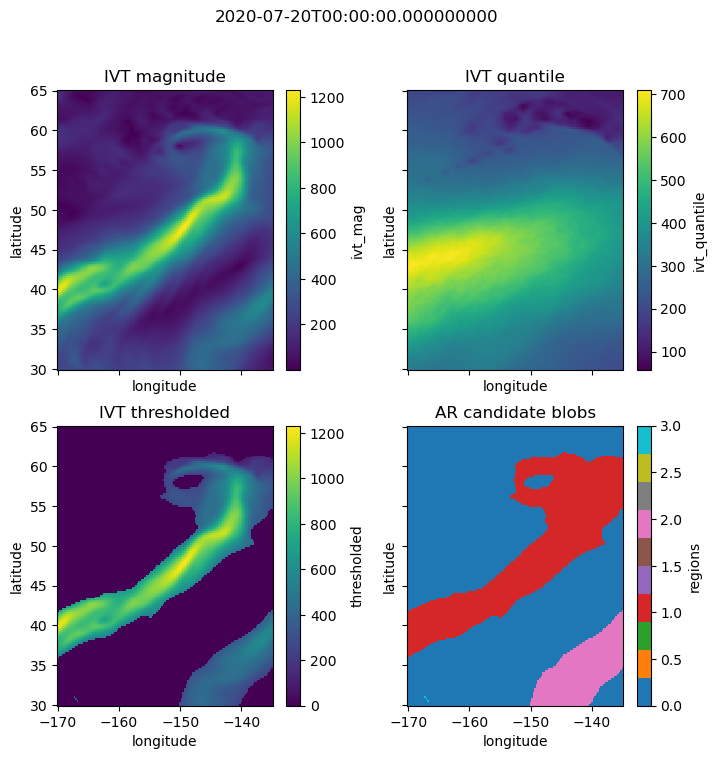

In [12]:
random_date = random.choice(list(output_ars.keys()))
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8,8))
plt.subplots_adjust(wspace=0.3)
plt.suptitle(random_date)

ivt_ds["ivt_mag"].sel(time=random_date).plot(ax=axes[0,0])
ivt_ds["ivt_quantile"].sel(time=random_date).plot(ax=axes[0,1])
ivt_ds["thresholded"].sel(time=random_date).plot(ax=axes[1,0])
labeled_regions.sel(time=random_date).plot(ax=axes[1,1], cmap="tab10")

axes[0,0].set_title("IVT magnitude")
axes[0,1].set_title("IVT quantile")
axes[1,0].set_title("IVT thresholded")
axes[1,1].set_title("AR candidate blobs")